In [1]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

import os

import numpy as np
import sep
import matplotlib.pyplot as plt

from astropy.io import fits

import gphelper as gp
import ImageTools as it
import DataTools as dt

In [2]:
def make_nonnegative(img):
    epsilon = 0 if len(img[img<0])==0 else img[img>0].min()
    return img + abs(img.min()) + epsilon

def get_random_spheroids(num=10):
    with open('../spheroids', 'r') as f:
        spheroids = np.array(f.readlines())
    
    if num==-1:
        num = len(spheroids)
    
    selected = np.random.choice(spheroids, num, replace=False)
    
    data_dir = os.path.join(os.getenv('HOME'), 'Documents/astro_data/orig_images')
    fmask = 'GDS_{}_{}.fits'
    f_string = os.path.join(data_dir, fmask)
    
    sources = []
    for s in selected:
        img = fits.getdata(f_string.format(s.strip(), 'h'))
        segmap = fits.getdata(f_string.format(s.strip(), 'segmap'))
        img_id = int(s.split('_')[1])
        sources.append((img.copy(), segmap.copy(), img_id))
        del img 
        del segmap
    
    return sources

In [22]:
def convergence_update(re, is_converged):
    tolerance = 1e-3
    
    if (interp_re_int/interp_int_limit-0.5 > tolerance):
        re = re**0.995
    elif (interp_re_int/interp_int_limit-0.5 < -tolerance):
        re = re**1.01
    else:
        is_converged = True
        
    return re, is_converged

def check_stop_condition(count, max_attempts, re):
    stop = False
    
    if count==max_attempts:
        stop = True
    elif 5*re >= 42:
        stop = True
        
    return stop

def segmap_too_small(src_map):
    area = src_map.sum()
    r = np.sqrt(area/np.pi)
    return r<=15

spheroids = get_random_spheroids(num=-1)
num_converged, total, num_too_small  = 0, len(spheroids), 0
found_res = []


for img, segmap, img_id in spheroids:
    src_map = segmap==img_id
    array_sep_likes = img.byteswap().newbyteorder()
    bkg = sep.Background(array_sep_likes, mask=src_map,bw=10,bh=10)
    img_sub = img-bkg

    cx, cy = it.img_center(img, src_map)
    xs, ys = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]).T)
    rs = np.sqrt(np.square(cx-xs) + np.square(cy-ys))

    
    if segmap_too_small(src_map):
        print(f'{img_id} segmap too small')
        #take measurement within segmap only
        rs = rs[src_map].flatten()
        fs = img_sub[src_map].flatten()
        
        sorted_rs = np.argsort(rs)
        rs = rs[sorted_rs]
        fs = fs[sorted_rs]
        fs[fs<0] = 0
        
        fs_int = np.cumsum(fs)
        
        re_idx = np.argmin(np.square(fs_int/fs_int.max()-0.5))
        re = rs[re_idx]
    else:
        # find using iterative method
        rs = rs.flatten()
        fs = img.flatten()
        fs_sub = img_sub.flatten()

        sorted_rs = np.argsort(rs)
        rs = rs[sorted_rs]
        fs = fs[sorted_rs]
        fs_sub = fs_sub[sorted_rs]

        fs[fs<0] = 0
        fs_sub[fs_sub<0] = 0

        fs_int = np.cumsum(fs)
        fs_sub_int = np.cumsum(fs_sub)

        re = 0.1 * rs.max()
        is_converged = False
        max_attempts = 1000
        count = 0

        while not is_converged:
            int_limit = 5 * re
            interp_re_int = np.interp(re, rs, fs_sub_int)
            interp_int_limit = np.interp(int_limit, rs, fs_sub_int)

            re, is_converged = convergence_update(re, is_converged)

            if not is_converged:
                is_converged = check_stop_condition(count, max_attempts, re)

            count += 1
        
    found_res.append(re)
        
    if len(spheroids)<5:
        plt.figure()
        plt.title(img_id)
        plt.semilogy(rs, fs_sub_int)
        plt.vlines([re], fs_sub_int.min(), fs_sub_int.max(), color='g', label='$R_e$')
        plt.vlines([int_limit], fs_sub_int.min(), fs_sub_int.max(), color='r', label="$5R_e$")
        plt.legend()
        plt.show()

7407 segmap too small
2558 segmap too small
10459 segmap too small
203 segmap too small
130 segmap too small
7487 segmap too small
2464 segmap too small
633 segmap too small
5553 segmap too small
13886 segmap too small
10061 segmap too small
230 segmap too small
11360 segmap too small
4578 segmap too small
7139 segmap too small
15902 segmap too small
4136 segmap too small
1810 segmap too small
273 segmap too small
7266 segmap too small
5693 segmap too small
10285 segmap too small
6433 segmap too small
10442 segmap too small
7018 segmap too small
17584 segmap too small
4583 segmap too small
13527 segmap too small
12827 segmap too small
10193 segmap too small
16713 segmap too small
10367 segmap too small
10954 segmap too small
3262 segmap too small
5199 segmap too small
1407 segmap too small
1808 segmap too small
14393 segmap too small
5435 segmap too small
11165 segmap too small
5948 segmap too small
11169 segmap too small
6881 segmap too small
10771 segmap too small
17216 segmap too sm

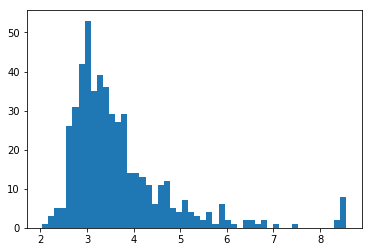

In [23]:
hist_res = found_res
plt.hist(hist_res, bins=50)
plt.show()
